0. 참고

https://www.kaggle.com/sarthakbatra/predicting-sales-tutorial

https://www.kaggle.com/dlarionov/feature-engineering-xgboost#Part-1,-perfect-features

# Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Malgun Gothic')

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)

In [269]:
a = pd.read_excel("s1_2017_trade_list.xls")
b = pd.read_excel("s1_2018_trade_list.xls")
c = pd.read_excel("s1_2019_trade_list.xls")

In [270]:
trade = pd.concat([a,b,c])

c:\users\minji\anaconda3\envs\jj\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [301]:
trade.isnull().sum()

개별배송비                        0
결제번호                     36752
결제수단                         0
결제일시(입금확인일)                  0
공급원가                        88
교환구분                         0
교환접수거부 사유                38559
교환접수거부 처리일               38559
교환철회 구분                  38553
교환철회 사유                  38553
교환철회일                    38545
네이버 페이 취소접수 구분           38553
네이버 포인트                      0
매출경로                         0
반송완료일                    38543
반품접수거부 사유                38560
반품접수거부 처리일               38560
반품철회 구분                  38539
반품철회 사유                  38539
반품철회일                    38517
발주일                          0
배송구분                         0
배송대기일                      880
배송번호                         0
배송비 정보                       0
배송시작일                        0
배송완료일                        0
배송유형                     36931
사용한 적립금액                     0
사용한 쿠폰명                  36487
상품 매입가                       0
상품 쿠폰 할인금액               38538
상품구매금액  

In [274]:
trade.shape

(46749, 110)

In [282]:
trade.loc[~trade['주문상품명'].str.contains('사은품')].shape

(38561, 110)

In [283]:
trade = trade.loc[~trade['주문상품명'].str.contains('사은품')]

In [285]:
trade['입금_발주_차이'] = trade['발주일'] - trade['결제일시(입금확인일)']

c:\users\minji\anaconda3\envs\jj\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [291]:
trade[trade['입금_발주_차이'].dt.days!=0].shape

(279, 111)

In [294]:
trade['차이여부'] = np.where(trade['발주일'] - trade['결제일시(입금확인일)'], 1, 0)

c:\users\minji\anaconda3\envs\jj\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [297]:
trade[trade['차이여부']!=0].shape

(3065, 112)

In [300]:
trade[trade['입금_발주_차이'].dt.days!=0]['입금_발주_차이'].dt.days.describe()

count   279.00
mean     10.01
std       8.56
min       1.00
25%       4.00
50%       8.00
75%      14.00
max      66.00
Name: 입금_발주_차이, dtype: float64

In [302]:
trade['입금_배송_차이'] = trade['배송시작일'] - trade['결제일시(입금확인일)']

c:\users\minji\anaconda3\envs\jj\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


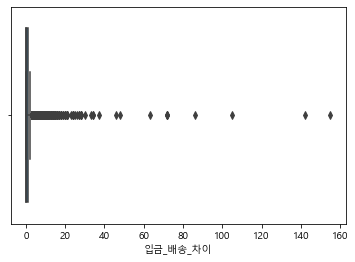

In [305]:
sns.boxplot(trade['입금_배송_차이'].dt.days)

In [306]:
trade['입금_배송_차이'].dt.days.describe()

count   38561.00
mean        0.77
std         2.10
min         0.00
25%         0.00
50%         0.00
75%         1.00
max       155.00
Name: 입금_배송_차이, dtype: float64

In [308]:
sum(np.where(trade['입금_배송_차이'].dt.days>1, 1, 0))

6100

In [310]:
sum(np.where(trade['입금_배송_차이'].dt.days>4, 1, 0))

621

In [313]:
sum(np.where(trade['입금_배송_차이'].dt.days>=7, 1, 0))

344

In [311]:
sum(np.where(trade['입금_배송_차이'].dt.days>3, 1, 0))

1025

In [3]:
data = pd.read_pickle('data.pkl')

In [4]:
data

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.00,0,19,5,10,0.00,0.00,0.00,0.00,1.00,0.41,0.09,0.04,0.13,0.07,0.16,0.15,0.10,0.09,0.10,0.14,1.08,0.96,0.81,0.94,0.15,0.00,1.03,1.08,-0.28,1.21,0,31,1,1,12,12
4488711,12,2,30,0.00,0,40,11,4,0.00,0.00,0.00,0.00,0.00,0.41,1.02,1.02,0.52,0.89,0.00,0.15,0.10,0.09,0.10,0.00,0.29,0.05,0.05,0.05,0.15,0.00,0.27,0.29,-0.48,1.21,0,31,1,1,11,11
4488712,12,2,31,0.00,0,37,11,1,0.00,0.00,0.00,0.00,0.00,0.41,0.54,0.60,0.54,0.30,0.00,0.15,0.10,0.09,0.10,0.00,0.23,0.06,0.05,0.06,0.15,0.00,0.27,0.23,-0.14,1.21,0,31,1,1,11,11
4488713,12,2,32,1.00,0,40,11,4,0.00,0.00,0.00,0.00,0.00,0.41,1.93,1.80,1.26,1.89,5.38,0.15,0.10,0.09,0.10,0.14,0.29,0.05,0.05,0.05,0.15,0.00,0.27,0.29,-0.41,1.21,0,31,-1,1,12,12
4488714,12,2,33,1.00,0,37,11,1,1.00,2.00,0.00,0.00,1.00,0.41,0.91,0.33,0.72,1.00,1.36,0.15,0.10,0.09,0.10,0.14,0.23,0.06,0.05,0.06,0.15,1.00,0.27,0.23,-0.23,1.21,0,31,1,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.00,20,55,13,2,1.00,0.00,0.00,0.00,0.00,0.26,0.05,0.02,0.07,0.59,0.00,0.13,0.13,0.14,0.14,0.00,0.20,0.13,0.09,0.13,0.14,0.50,0.15,0.20,-0.48,-0.29,10,30,1,-1,11,11
11128000,34,45,16188,0.00,20,64,14,42,0.00,0.00,0.00,0.00,0.00,0.26,0.02,0.07,0.00,0.00,0.00,0.13,0.13,0.00,0.00,0.00,0.16,0.09,0.11,0.09,0.14,0.00,0.24,0.16,0.08,-0.29,10,30,-1,-1,2,2
11128001,34,45,15757,0.00,20,55,13,2,0.00,0.00,0.00,0.00,0.00,0.26,0.11,0.07,0.10,0.25,0.18,0.13,0.13,0.14,0.14,0.18,0.20,0.13,0.09,0.13,0.14,0.00,0.15,0.20,0.16,-0.29,10,30,1,-1,34,34
11128002,34,45,19648,0.00,20,40,11,4,0.00,0.00,0.00,0.00,0.00,0.26,0.05,0.07,0.17,0.09,0.00,0.13,0.13,0.14,0.14,0.00,0.22,0.08,0.10,0.08,0.14,0.00,0.22,0.22,-0.09,-0.29,10,30,-1,-1,11,11


# 패커스 매출 현황

In [5]:
sales_origin = pd.read_csv("sales_cleaned.csv", encoding='CP949')

In [280]:
sales_origin.shape

(38190, 22)

In [6]:
sales_origin['상품번호'] = sales_origin['상품번호'].astype(int)

In [7]:
prod_list = pd.read_excel("s2_product_list.xls", encoding='CP949')

In [8]:
prod_list.shape

(1020, 51)

In [9]:
prod_cat = pd.read_csv("product_category_revised.csv")

In [10]:
prod_cat.shape

(306, 12)

In [11]:
tmp = dict()
tmp2 = []
for col in prod_cat.columns.values[1:]:
    
    tmp[col] = prod_cat[prod_cat[col].notnull()][col].to_list()
    for i in prod_cat[prod_cat[col].notnull()][col]:
        tmp2.append(i)

In [12]:
list(set(tmp2))

['105파이 다용도컵(검정) 100개',
 '쥬스 450 152개(1BOX)',
 '사각 죽용기 뚜껑 500개 1BOX',
 '위생 롤백 2호 (6개)',
 '비닐봉투 맛난거들었쪙 중 백색 200개',
 '사각밀폐용기 중 투명 400개 1set(2박스/850ml)',
 '10~13온스 명화홀더24종 랜덤 500개 1박스',
 '125파이 원형용기(용기만) 600개',
 '소량 PP 170mm 다용도A수저 검정 100개',
 '실링용기 23194-5A 백색 100개 1박스',
 '150mm 빙수 스푼 검정 2,000개 1박스',
 '웰빙 안새내 특대 10개(1BOX)',
 '실링용기 2-5호 (21호) 검정 900ml 800개 1박스',
 'PP 6칸 도시락용기 L1 200개 1박스',
 '스트로우 일반형 블랙 빨대 21cm 10,000개 1박스',
 '실링용기 71호 백색 2,200ml 400개 1박스',
 '92파이 아이스컵 뚜껑 돔형 구멍있음 PET 1000개 1박스',
 '고강도 감자탕용기 특대 100개 1set(2박스)',
 'PSP 고기접시 적그물 27호 1,000개(1BOX)',
 '195파이 뚜껑 300개 1박스',
 '12 16 20온스 종이컵뚜껑 타공형 일반형 1,000개 1박스',
 '150mm 빙수 스푼 백색 2,000개 1박스',
 '225파이 탕용기 소 100개 SET',
 '실링용기 5호 TI-506 백색 230ml  2,400개 1박스',
 '반찬용기 204-2 2칸 블랙 800개 1set(2박스)',
 '소량 사각 죽용기 중 920ml 100개',
 '98파이 24온스 약720ml 아이스컵 PET 1000개 1박스',
 '목향 양념단지 2호 10개(1BOX)',
 '사각 225 냄비 뚜껑 200개 1박스',
 '98파이 16온스 약 480ml 아이스컵 PET 1000개 1박스',
 'PSP 수산물접시 흑색 18호 1,000개(1BOX)',
 '170파이 원형 샐러드 1칸 550ml x 1 검정 400개 1set(2박스)',
 '소

In [13]:
tmp_df = pd.DataFrame(list(set(tmp2)))
tmp_df.columns = ['주문상품명']

In [14]:
for i in prod_cat.columns.values[1:]:
    tmp_df[i] = np.where(tmp_df['주문상품명'].isin(tmp[i]), 1, 0)
    #tmp_df[i] = np.zeros(564)
    tmp_df[i] = tmp_df[i].astype(int)

In [15]:
tmp_df

,주문상품명,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small
0,105파이 다용도컵(검정) 100개,0,1,1,1,1,0,0,0,0,0,0
1,쥬스 450 152개(1BOX),0,0,0,0,0,0,1,0,0,0,0
2,사각 죽용기 뚜껑 500개 1BOX,0,0,0,1,1,0,0,0,0,0,0
3,위생 롤백 2호 (6개),0,0,0,0,0,0,1,0,0,0,0
4,비닐봉투 맛난거들었쪙 중 백색 200개,0,0,0,0,0,0,0,0,1,0,0
5,사각밀폐용기 중 투명 400개 1set(2박스/850ml),0,1,1,1,1,0,0,0,0,0,0
6,10~13온스 명화홀더24종 랜덤 500개 1박스,0,0,0,0,0,0,1,0,0,0,0
7,125파이 원형용기(용기만) 600개,0,1,1,1,1,0,0,0,0,0,0
8,소량 PP 170mm 다용도A수저 검정 100개,0,0,0,0,0,0,0,0,1,0,0
9,실링용기 23194-5A 백색 100개 1박스,0,0,0,0,0,0,0,0,1,0,0


## top 120

### 매출순

> 한번이라도 팔린 패커스 상품 681개 중 상위 135개의 상품이 매출의 90%를 차지!

따라서 매출 상위 135개의 상품에 대해서만 수요예측 실시

In [16]:
top_100 = sales_origin.groupby(['상품번호', '주문상품명'], as_index=False)['상품구매금액'].sum().nlargest(135, '상품구매금액')
top_100

,상품번호,주문상품명,상품구매금액
541,1374,210파이 중화면용기 중 300개 1박스,143001620
196,455,PP 5칸 도시락용기 DS 200개 1박스(돈까스 용기),127488040
540,1373,210파이 중화면용기 소 300개 1박스,123014280
274,608,195파이 탕용기 대 300개 1set(2박스),115630790
272,603,195파이 미니탕용기 블랙 300개 1set(2박스),102839700
355,1077,195파이 탕용기 소 300개 1set(2박스),100257050
337,1036,210파이 중화면용기 중 400개 1박스,84878120
336,1035,210파이 중화면용기 소 400개 1박스,69665850
47,92,"사각 죽용기 대 1,050ml 500개 1set(2박스)",62003750
43,88,사각 죽용기 소 550ml 500개 1set(2박스),59786380


In [17]:
top_100_sales = sales_origin.loc[sales_origin['상품번호'].isin(top_100['상품번호'])]

In [18]:
top_100_sales['상품번호'].nunique()

135

## 최근 판매상품 파악

마지막 판매일이 2019년 4,5,6월인 상품만 추출

In [19]:
last_sell_day = top_100_sales.groupby(['상품번호', '주문상품명'])['결제일'].max().reset_index(name='마지막판매일')
recent_sell_prod = last_sell_day.loc[last_sell_day['마지막판매일']>='2019-04-01'].reset_index(drop=True)

In [20]:
recent_sell_prod.shape

(130, 3)

In [21]:
recent_sell_prod['상품번호'].nunique()

130

In [22]:
recent_sell_prod

,상품번호,주문상품명,마지막판매일
0,38,"70파이 다용도컵 세트 1호 소 70ml 백색 PS 3,000개 1set(2박스)",2019-05-31
1,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",2019-05-27
2,40,"75파이 다용도컵 세트 3호 소 150ml 백색 PS 3,000개 1set(2박스)",2019-05-29
3,41,"75파이 다용도컵 세트 3호 대 165ml 백색 PS 3,000개 1set(2박스)",2019-05-27
4,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",2019-05-29
5,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",2019-05-30
6,44,"105파이 다용도컵 세트 5호 중 300ml 백색 PS 1,000개 1set(2박스)",2019-05-30
7,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",2019-05-30
8,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",2019-05-27
9,47,"70파이 다용도컵 세트 1호 특소 50ml 백색 PS 3,000개 1set(2박스)",2019-05-28


In [23]:
sales = sales_origin.loc[sales_origin['상품번호'].isin(recent_sell_prod['상품번호'])]
#print(recent_sales.shape)
sales

,결제일,결제년월,주문번호,주문경로,지역,상품번호,상품명(패커스(PACKUS)),주문상품명,수량,공급원가,사용한적립금액,상품매입가,상품구매금액,상품별추가할인금액,옵션+판매가,총결제금액,총배송비,총상품구매금액,총주문금액,주문서쿠폰할인금액,쿠폰할인금액,판매가
0,2017-01-02,201701,20170101-0000015,모바일웹,전북,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)","105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,51700.00,0,66500,66500,0,66500,70500,4000,66500,70500,0.00,0,66500
2,2017-01-18,201701,20170118-0000019,PC쇼핑몰,경북,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)","105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,58300.00,0,73700,73700,0,73700,72700,4000,73700,77700,5000.00,5000,73700
8,2017-02-08,201702,20170208-0000013,네이버 페이,경기,82,"300파이 원형 찜용기 중 투명 3,500ml 100개 1set(2박스)","300파이 원형 찜용기 중 투명 3,500ml 100개 1set(2박스)",1,59400.00,0,75600,75600,0,75600,79600,4000,75600,79600,0.00,0,75600
9,2017-02-09,201702,20170209-0000021,PC쇼핑몰,서울,90,사각 죽용기 중 920ml 500개 1set(2박스),사각 죽용기 중 920ml 500개 1set(2박스),1,79750.00,0,88750,88750,0,88750,170500,8000,167500,175500,5000.00,5000,88750
10,2017-02-09,201702,20170209-0000021,PC쇼핑몰,서울,88,사각 죽용기 소 550ml 500개 1set(2박스),사각 죽용기 소 550ml 500개 1set(2박스),1,71500.00,0,78750,78750,0,78750,170500,8000,167500,175500,5000.00,5000,78750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38184,2019-06-05,201906,20190602-0000017,모바일웹,전북,1373,210파이 중화면용기 소 300개 1박스,210파이 중화면용기 소 300개 1박스,1,34650.00,0,34650,52400,0,52400,267370,0,267370,267370,0.00,0,52400
38185,2019-06-05,201906,20190602-0000017,모바일웹,전북,1374,210파이 중화면용기 중 300개 1박스,210파이 중화면용기 중 300개 1박스,1,42900.00,0,42900,60900,0,60900,267370,0,267370,267370,0.00,0,60900
38187,2019-06-04,201906,20190604-0000018,모바일웹,대구,608,195파이 탕용기 대 300개 1set(2박스),195파이 탕용기 대 300개 1set(2박스),1,47850.00,0,47850,61900,0,61900,61900,0,61900,61900,0.00,0,61900
38188,2019-06-19,201906,20190619-0000037,모바일웹,경남,1373,210파이 중화면용기 소 300개 1박스,210파이 중화면용기 소 300개 1박스,1,34650.00,0,34650,52400,0,52400,52400,0,52400,52400,0.00,0,52400


## 목적

- 201701 ~ 201904 의 매출데이터를 가지고 201905의 매출을 예측
- 201906의 데이터는 한달이 온전히 있지 않아서..!

# 월별 상품수

In [24]:
monthly_sales = sales.groupby(['결제년월', '상품번호', '주문상품명'], as_index=False)['수량'].sum()
monthly_sales

,결제년월,상품번호,주문상품명,수량
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1
...,...,...,...,...
2146,201906,1168,130파이 찬용기 대 350ml 800개 1set(2박스),4
2147,201906,1169,130파이 찬용기 중 250ml 800개 1set(2박스),1
2148,201906,1232,반찬용기 202 1칸 블랙 1000개 1set(2박스),1
2149,201906,1373,210파이 중화면용기 소 300개 1박스,2


In [25]:
monthly_sales = monthly_sales.loc[monthly_sales['결제년월']<201906]

In [26]:
monthly_sales.groupby(['결제년월'])['주문상품명'].nunique()

결제년월
201701      2
201702     11
201703     17
201704     12
201705     17
201706     30
201707     32
201708     30
201709     36
201710     36
201711     53
201712     50
201801     64
201802     60
201803     72
201804     85
201805     98
201806    107
201807    110
201808    115
201809    116
201810    119
201811    123
201812    124
201901    120
201902    125
201903    122
201904    126
201905    125
Name: 주문상품명, dtype: int64

> 월별로 팔린 상품들이 다름!

## 상품 카테고리 추가

In [27]:
monthly_sales = pd.merge(monthly_sales, tmp_df, on='주문상품명', how='left')

In [28]:
monthly_sales.head()

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## train test 나누기

In [29]:
train = sales.loc[sales['결제년월']<201905]
test = sales.loc[sales['결제년월']==201905]

In [30]:
display(train.head(3), test.head(3))

,결제일,결제년월,주문번호,주문경로,지역,상품번호,상품명(패커스(PACKUS)),주문상품명,수량,공급원가,사용한적립금액,상품매입가,상품구매금액,상품별추가할인금액,옵션+판매가,총결제금액,총배송비,총상품구매금액,총주문금액,주문서쿠폰할인금액,쿠폰할인금액,판매가
0,2017-01-02,201701,20170101-0000015,모바일웹,전북,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)","105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,51700.00,0,66500,66500,0,66500,70500,4000,66500,70500,0.00,0,66500
2,2017-01-18,201701,20170118-0000019,PC쇼핑몰,경북,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)","105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,58300.00,0,73700,73700,0,73700,72700,4000,73700,77700,5000.00,5000,73700
8,2017-02-08,201702,20170208-0000013,네이버 페이,경기,82,"300파이 원형 찜용기 중 투명 3,500ml 100개 1set(2박스)","300파이 원형 찜용기 중 투명 3,500ml 100개 1set(2박스)",1,59400.00,0,75600,75600,0,75600,79600,4000,75600,79600,0.00,0,75600


,결제일,결제년월,주문번호,주문경로,지역,상품번호,상품명(패커스(PACKUS)),주문상품명,수량,공급원가,사용한적립금액,상품매입가,상품구매금액,상품별추가할인금액,옵션+판매가,총결제금액,총배송비,총상품구매금액,총주문금액,주문서쿠폰할인금액,쿠폰할인금액,판매가
33953,2019-05-02,201905,20190425-0000795,모바일웹,서울,1205,"175mm 수저 백색 1,500개 맛있숟갈","175mm 수저 백색 1,500개 맛있숟갈",1,24750.00,0,24750,35210,0,35210,136210,0,136210,136210,0.00,0,35210
33955,2019-05-02,201905,20190425-0000795,모바일웹,서울,1089,"95파이 다용도컵 세트 4호 대 270ml 블랙 PS-1,000개 1set(2박스)","95파이 다용도컵 세트 4호 대 270ml 블랙 PS-1,000개 1set(2박스)",1,46200.00,0,46200,63620,0,63620,136210,0,136210,136210,0.00,0,63620
34277,2019-05-02,201905,20190429-0000765,PC쇼핑몰,대구,1374,210파이 중화면용기 중 300개 1박스,210파이 중화면용기 중 300개 1박스,3,42900.00,0,34320,182700,0,60900,404390,0,404390,404390,0.00,0,60900


### train / test 월별 상품수

In [31]:
sales['상품번호'].nunique()

130

In [32]:
train['주문상품명'].nunique(), test['주문상품명'].nunique()

(130, 125)

In [33]:
list(set(train['상품번호']) - set(test['상품번호']))

[1350, 1132, 812, 592, 442]

In [34]:
list(set(train['주문상품명']) - set(test['주문상품명']))

['사각 270 알루미늄 직화 냄비 대 2,750ml 200개 1박스',
 '실링기계 201H 수동 식품포장 몰드교체형 몰드1개포함',
 '실링기계 푸디 수동 식품포장 몰드교체형 몰드1개포함',
 '175mm 수저 투명 1,500개  맛있숟갈',
 '130파이 원형용기 대 470ml 백색 PP 1,200개 1set(2박스)']

# Feature Engineering

## 결제년월 LabelEncoding

In [35]:
le = LabelEncoder()
monthly_sales['기준년월'] = le.fit_transform(monthly_sales['결제년월'])
monthly_sales.head()

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1


In [36]:
sales['기준년월'] = le.fit_transform(sales['결제년월'])

c:\users\minji\anaconda3\envs\jj\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Target lags

- 시차종속변수

In [37]:
def lag_feature(df, lags, col):
    tmp = df[['기준년월', '주문상품명', col]]
    tmp2 = df.copy()
    
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['기준년월','주문상품명', col+'_lag_'+str(i)]
        shifted['기준년월'] += i
        tmp2 = pd.merge(tmp2, shifted, on=['기준년월', '주문상품명'], how='left')
        
    return tmp2

해당 상품이 과거에 얼마나 팔렸는 지를 변수로 생성

최근 1, 2, 3개월 & 6, 12개월

In [38]:
monthly_sales_2 = lag_feature(monthly_sales, [1,2,3,6, 12], '수량')

In [39]:
monthly_sales_2

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan


In [40]:
monthly_sales_2[monthly_sales_2['상품번호']==1373]

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12
1516,201812,1373,210파이 중화면용기 소 300개 1박스,215,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23,nan,nan,nan,nan,nan
1636,201901,1373,210파이 중화면용기 소 300개 1박스,370,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,24,215.00,nan,nan,nan,nan
1761,201902,1373,210파이 중화면용기 소 300개 1박스,324,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25,370.00,215.00,nan,nan,nan
1883,201903,1373,210파이 중화면용기 소 300개 1박스,383,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26,324.00,370.00,215.00,nan,nan
2009,201904,1373,210파이 중화면용기 소 300개 1박스,580,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27,383.00,324.00,370.00,nan,nan
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan


## Mean encoded features

### 한시차 전의 전체 상품 판매 수량 트렌드

In [41]:
group = monthly_sales.groupby(['기준년월'])['수량'].mean().reset_index(name='date_avg_item_cnt')

monthly_sales_3 = pd.merge(monthly_sales_2, group, on=['기준년월'], how='left')
monthly_sales_3['date_avg_item_cnt'] = monthly_sales_3['date_avg_item_cnt'].astype(np.float16)

monthly_sales_3 = lag_feature(monthly_sales_3, [1], 'date_avg_item_cnt')

monthly_sales_3.drop(['date_avg_item_cnt'], axis=1, inplace=True)

### 한 시차 전의 카테고리별 평균판매수량

In [42]:
for category in prod_cat.columns[1:]:
    group = monthly_sales.loc[monthly_sales[category]==1].groupby(['기준년월'])['수량'].mean().reset_index(name='date_cat_{}_avg_item_cnt'.format(category))

    monthly_sales_3 = pd.merge(monthly_sales_3, group, on=['기준년월'], how='left')
    monthly_sales_3['date_cat_{}_avg_item_cnt'.format(category)] = monthly_sales_3['date_cat_{}_avg_item_cnt'.format(category)].astype(np.float16)

    monthly_sales_3 = lag_feature(monthly_sales_3, [1], 'date_cat_{}_avg_item_cnt'.format(category))

    monthly_sales_3.drop(['date_cat_{}_avg_item_cnt'.format(category)], axis=1, inplace=True)    

### 3개월이동평균, 표준편차

In [43]:
rolling_mean = pd.DataFrame()
for num in sorted(monthly_sales['상품번호'].unique()):
    tmp = pd.DataFrame()
    prod_num = monthly_sales_3.loc[monthly_sales_3['상품번호']==num]
    tmp['상품번호'] = np.repeat(num, len(prod_num['기준년월']))
    tmp['기준년월'] = [i+1 for i in prod_num['기준년월']]
    tmp['rolling_mean_3'] = prod_num['수량'].rolling(3).mean().reset_index(name='rolling_mean_3')['rolling_mean_3']
    rolling_mean = pd.concat([rolling_mean, tmp])

In [44]:
rolling_std = pd.DataFrame()
for num in sorted(monthly_sales['상품번호'].unique()):
    tmp = pd.DataFrame()
    prod_num = monthly_sales_3.loc[monthly_sales_3['상품번호']==num]
    tmp['상품번호'] = np.repeat(num, len(prod_num['기준년월']))
    tmp['기준년월'] = [i+1 for i in prod_num['기준년월']]
    tmp['rolling_std_3'] = prod_num['수량'].rolling(3).std().reset_index(name='rolling_std_3')['rolling_std_3']
    rolling_std = pd.concat([rolling_std, tmp])

In [45]:
monthly_sales_3 = pd.merge(monthly_sales_3, pd.merge(rolling_std, rolling_mean, on=['상품번호', '기준년월']), on=['상품번호', '기준년월'], how='left')

## Trend features

Price trend for the last six months.

### 해당 상품의 평균상품판매가

In [46]:
group = train.groupby(['주문상품명'])['판매가'].mean().reset_index(name='item_avg_item_price')
monthly_sales_4 = pd.merge(monthly_sales_3, group, on=['주문상품명'], how='left')
monthly_sales_4

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,item_avg_item_price
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,73672.40
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,86198.08
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,71968.45
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66618.18
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,69127.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,63148.06
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,76207.78
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,55700.07
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,65518.27


### 해당 상품의 월별 평균상품판매가

In [47]:
group = train.groupby(['결제년월','주문상품명'])['판매가'].mean().reset_index(name='date_item_avg_item_price')
monthly_sales_4 = pd.merge(monthly_sales_4, group, on=['결제년월','주문상품명'], how='left')
monthly_sales_4

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,item_avg_item_price,date_item_avg_item_price
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,73672.40,66500.00
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,86198.08,73700.00
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,71968.45,68100.00
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66618.18,53300.00
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,69127.64,55100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,63148.06,nan
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,76207.78,nan
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,55700.07,nan
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,65518.27,nan


In [48]:
lags = [1,2,3,4,5,6]

In [49]:
monthly_sales_5 = lag_feature(monthly_sales_4, lags, 'date_item_avg_item_price')
monthly_sales_5

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,73672.40,66500.00,nan,nan,nan,nan,nan,nan
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,86198.08,73700.00,nan,nan,nan,nan,nan,nan
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,71968.45,68100.00,nan,nan,nan,nan,nan,nan
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66618.18,53300.00,nan,nan,nan,nan,nan,nan
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,69127.64,55100.00,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,63148.06,nan,56890.00,56890.00,59006.36,68530.00,68530.00,68530.00
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,76207.78,nan,67650.00,67650.00,83550.00,83550.00,83550.00,81070.00
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,55700.07,nan,51640.79,50270.00,54309.66,63470.00,63470.00,nan
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,65518.27,nan,60131.04,58810.00,64059.42,75240.00,75240.00,nan


### delta_price_lag : 평균적인 판매가와 얼마나 차이나는지..?

(n시차전의 평균판매가 - 평균판매가)/평균판매가 => 뭔가 이상

In [50]:
for i in lags:
    monthly_sales_5['delta_price_lag_'+str(i)] = (monthly_sales_5['date_item_avg_item_price_lag_'+str(i)] - monthly_sales_5['item_avg_item_price']) / monthly_sales_5['item_avg_item_price']

In [51]:
monthly_sales_5

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,73672.40,66500.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,86198.08,73700.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,71968.45,68100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66618.18,53300.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,69127.64,55100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,63148.06,nan,56890.00,56890.00,59006.36,68530.00,68530.00,68530.00,-0.10,-0.10,-0.07,0.09,0.09,0.09
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,76207.78,nan,67650.00,67650.00,83550.00,83550.00,83550.00,81070.00,-0.11,-0.11,0.10,0.10,0.10,0.06
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,55700.07,nan,51640.79,50270.00,54309.66,63470.00,63470.00,nan,-0.07,-0.10,-0.02,0.14,0.14,nan
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,65518.27,nan,60131.04,58810.00,64059.42,75240.00,75240.00,nan,-0.08,-0.10,-0.02,0.15,0.15,nan


In [52]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [53]:
monthly_sales_5['delta_price_lag'] = monthly_sales_5.apply(select_trend, axis=1)
monthly_sales_5['delta_price_lag'].fillna(0, inplace=True)

In [54]:
monthly_sales_5

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,73672.40,66500.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,86198.08,73700.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,71968.45,68100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66618.18,53300.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,69127.64,55100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,63148.06,nan,56890.00,56890.00,59006.36,68530.00,68530.00,68530.00,-0.10,-0.10,-0.07,0.09,0.09,0.09,-0.10
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,76207.78,nan,67650.00,67650.00,83550.00,83550.00,83550.00,81070.00,-0.11,-0.11,0.10,0.10,0.10,0.06,-0.11
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,55700.07,nan,51640.79,50270.00,54309.66,63470.00,63470.00,nan,-0.07,-0.10,-0.02,0.14,0.14,nan,-0.07
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,65518.27,nan,60131.04,58810.00,64059.42,75240.00,75240.00,nan,-0.08,-0.10,-0.02,0.15,0.15,nan,-0.08


In [55]:
monthly_sales_5

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,73672.40,66500.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,86198.08,73700.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,71968.45,68100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,66618.18,53300.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,69127.64,55100.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,63148.06,nan,56890.00,56890.00,59006.36,68530.00,68530.00,68530.00,-0.10,-0.10,-0.07,0.09,0.09,0.09,-0.10
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,76207.78,nan,67650.00,67650.00,83550.00,83550.00,83550.00,81070.00,-0.11,-0.11,0.10,0.10,0.10,0.06,-0.11
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,55700.07,nan,51640.79,50270.00,54309.66,63470.00,63470.00,nan,-0.07,-0.10,-0.02,0.14,0.14,nan,-0.07
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,65518.27,nan,60131.04,58810.00,64059.42,75240.00,75240.00,nan,-0.08,-0.10,-0.02,0.15,0.15,nan,-0.08


### 판매가 변화율

(해당월의 평균판매가 - 한시차전의 평균판매가)/한시차전의 평균판매가

In [56]:
monthly_sales_5['delta_price'] = (monthly_sales_5['date_item_avg_item_price'] - monthly_sales_5['date_item_avg_item_price_lag_1'])/monthly_sales_5['date_item_avg_item_price_lag_1']

### 필요없는 컬럼 삭제

In [57]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

In [58]:
monthly_sales_5.drop(fetures_to_drop, axis=1, inplace=True)

## Special features

In [59]:
matrix = monthly_sales_5.copy()

In [60]:
matrix['month'] = matrix['기준년월'] % 12

Number of days in a month. There are no leap years.

In [61]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [62]:
matrix

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,delta_price_lag,delta_price,month,days
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31
2,201702,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28
3,201702,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28
4,201702,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201905,1312,실링용기 2-5호 (21호) 백색 900ml 800개 1박스,19,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,24.00,28.00,14.00,15.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,7.21,22.00,-0.10,nan,4,31
2133,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,3.61,8.00,-0.11,nan,4,31
2134,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,134.06,429.00,-0.07,nan,4,31
2135,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,nan,nan,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,nan,nan,135.86,418.33,-0.08,nan,4,31


### 처음 팔린 결제년월

In [63]:
sales.groupby('상품번호')['결제년월'].min()

상품번호
38      201703
39      201702
40      201703
41      201706
42      201702
43      201702
44      201702
45      201701
46      201701
47      201704
68      201703
70      201709
72      201703
74      201711
76      201801
78      201801
80      201711
82      201702
84      201704
86      201703
88      201702
90      201702
92      201702
94      201703
96      201801
104     201703
140     201702
172     201702
176     201703
184     201705
188     201703
207     201705
215     201706
217     201702
248     201703
250     201706
378     201707
379     201706
380     201711
381     201710
382     201711
388     201706
391     201706
392     201706
393     201706
395     201706
397     201706
437     201707
440     201801
442     201711
445     201711
446     201707
447     201708
449     201708
450     201711
451     201707
455     201707
478     201711
479     201710
480     201712
481     201709
483     201711
592     201801
602     201711
603     201711
605     201711
608  

In [64]:
item_first_sale = sales.groupby('상품번호')['기준년월'].min().reset_index(name='item_first_sale')

In [65]:
matrix = pd.merge(matrix, item_first_sale, on='상품번호')

### 삼륭물산 주가

In [66]:
sm_stock= pd.read_csv("sm_stock.csv", encoding='CP949')
stock_info = sm_stock.loc[sm_stock['날짜']<='2019-04-30'].groupby(['결제년월'])['종가'].mean().reset_index(name='주가')

In [67]:
stock = pd.DataFrame()
stock['결제년월'] = [i.strftime('%Y%m') for i in pd.date_range('20170101', '20190531', freq='1m')]
stock['주가_lag_1'] = stock_info['주가']
stock['결제년월'] = stock['결제년월'].astype(int)

In [68]:
matrix = pd.merge(matrix, stock, on='결제년월')

In [69]:
matrix

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,delta_price_lag,delta_price,month,days,item_first_sale,주가_lag_1
0,201701,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,0,7220.00
1,201701,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0,31,0,7220.00
2,201704,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,3,30,0,6385.00
3,201704,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3,3.00,4.00,nan,nan,nan,1.59,nan,1.00,1.00,1.00,1.00,2.00,nan,nan,nan,nan,nan,nan,nan,-0.16,0.05,3,30,1,6385.00
4,201704,88,사각 죽용기 소 550ml 500개 1set(2박스),2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3,5.00,2.00,nan,nan,nan,1.59,nan,1.00,1.00,1.00,1.00,2.00,nan,nan,nan,nan,nan,nan,nan,-0.23,0.15,3,30,1,6385.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,201702,90,사각 죽용기 중 920ml 500개 1set(2박스),2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28,1,7020.00
2133,201702,92,"사각 죽용기 대 1,050ml 500개 1set(2박스)",1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28,1,7020.00
2134,201702,140,"170mm 수저 투명 1,500개 1박스",1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28,1,7020.00
2135,201702,172,PP 6칸 도시락용기 02 200개 1박스,1,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,1,28,1,7020.00


### Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [70]:
matrix = matrix[matrix['기준년월'] > 11]

In [71]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

c:\users\minji\anaconda3\envs\jj\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [72]:
matrix = matrix.fillna(0)

In [73]:
matrix

,결제년월,상품번호,주문상품명,수량,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,기준년월,수량_lag_1,수량_lag_2,수량_lag_3,수량_lag_6,수량_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,delta_price_lag,delta_price,month,days,item_first_sale,주가_lag_1
298,201801,45,"105파이 다용도컵 세트 5호 대 370ml 백색 PS 1,000개 1set(2박스)",9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,2.00,5.00,3.00,1.00,1.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.53,3.33,0.07,0.00,0,31,0,4985.26
299,201801,46,"105파이 다용도컵 세트 5호 특대 400ml 백색 PS 1,000개 1set(2박스)",6,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,12,3.00,6.00,3.00,1.00,1.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.73,4.00,-0.03,0.00,0,31,0,4985.26
300,201801,39,"70파이 다용도컵 세트 2호 대 80ml 백색 PS 3,000개 1set(2박스)",2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,1.00,1.00,0.00,1.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,0.00,1.00,-0.02,0.00,0,31,1,4985.26
301,201801,42,"95파이 다용도컵 세트 4호 소 200ml 백색 PS 1,000개 1set(2박스)",11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,13.00,9.00,11.00,2.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,2.00,11.00,-0.03,0.00,0,31,1,4985.26
302,201801,43,"95파이 다용도컵 세트 4호 대 270ml 백색 PS 1,000개 1set(2박스)",9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,4.00,3.00,6.00,2.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.53,4.33,-0.03,0.00,0,31,1,4985.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,201905,1316,"실링용기 3호 검정 650ml 1,200개 1박스",14,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,28,11.00,9.00,4.00,5.00,0.00,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,0.00,0.00,3.61,8.00,-0.11,0.00,4,31,22,5118.41
2105,201905,1373,210파이 중화면용기 소 300개 1박스,364,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,580.00,383.00,324.00,0.00,0.00,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,0.00,0.00,134.06,429.00,-0.07,0.00,4,31,23,5118.41
2106,201905,1374,210파이 중화면용기 중 300개 1박스,356,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,575.00,347.00,333.00,0.00,0.00,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,0.00,0.00,135.86,418.33,-0.08,0.00,4,31,23,5118.41
2107,201905,1375,210파이 중화면용기 대 300개 1박스,63,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28,74.00,59.00,57.00,0.00,0.00,34.97,228.00,51.19,18.05,18.91,19.44,13.00,5.00,6.00,29.19,0.00,0.00,9.29,63.33,-0.10,0.00,4,31,23,5118.41


# Modeling

In [74]:
data = matrix.copy()

In [75]:
data.drop(['결제년월', '주문상품명'],1, inplace=True)

In [76]:
data = data.rename(columns={'상품번호':'prod_num', '수량':'item_cnt', '기준년월':'ym', '수량_lag_1':'item_cnt_lag_1', '수량_lag_2':'item_cnt_lag_2', '수량_lag_3':'item_cnt_lag_3', '수량_lag_6':'item_cnt_lag_6', '수량_lag_12':'item_cnt_lag_12', '주가_lag_1':'stock_lag_1'})

In [77]:
data2 = pd.concat([data, pd.get_dummies(data['prod_num'], drop_first=True, prefix='prod_num_')], 1)

In [78]:
data2.head()

,prod_num,item_cnt,best,chinese,japanese,korean,western,sealing,bakerycafe,agri,kitchen,sticker,small,ym,item_cnt_lag_1,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_6,item_cnt_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,delta_price_lag,delta_price,month,days,item_first_sale,stock_lag_1,prod_num__39,prod_num__40,prod_num__41,prod_num__42,prod_num__43,prod_num__44,prod_num__45,prod_num__46,prod_num__47,prod_num__68,prod_num__70,prod_num__72,prod_num__74,prod_num__76,prod_num__78,prod_num__80,prod_num__82,prod_num__84,prod_num__86,prod_num__88,prod_num__90,prod_num__92,prod_num__94,prod_num__96,prod_num__104,prod_num__140,prod_num__172,prod_num__176,prod_num__184,prod_num__188,prod_num__207,prod_num__215,prod_num__217,prod_num__248,prod_num__250,prod_num__378,prod_num__379,prod_num__380,prod_num__381,prod_num__382,prod_num__388,prod_num__391,prod_num__392,prod_num__393,prod_num__395,prod_num__397,prod_num__437,prod_num__440,prod_num__442,prod_num__445,prod_num__446,prod_num__447,prod_num__449,prod_num__450,prod_num__451,prod_num__455,prod_num__478,prod_num__479,prod_num__480,prod_num__481,prod_num__483,prod_num__592,prod_num__602,prod_num__603,prod_num__605,prod_num__608,prod_num__812,prod_num__928,prod_num__937,prod_num__953,prod_num__957,prod_num__962,prod_num__966,prod_num__1038,prod_num__1055,prod_num__1058,prod_num__1059,prod_num__1060,prod_num__1069,prod_num__1070,prod_num__1071,prod_num__1072,prod_num__1077,prod_num__1082,prod_num__1083,prod_num__1084,prod_num__1085,prod_num__1089,prod_num__1091,prod_num__1105,prod_num__1106,prod_num__1121,prod_num__1122,prod_num__1123,prod_num__1126,prod_num__1127,prod_num__1131,prod_num__1132,prod_num__1139,prod_num__1167,prod_num__1168,prod_num__1169,prod_num__1180,prod_num__1181,prod_num__1182,prod_num__1191,prod_num__1205,prod_num__1226,prod_num__1227,prod_num__1228,prod_num__1231,prod_num__1232,prod_num__1233,prod_num__1234,prod_num__1235,prod_num__1266,prod_num__1274,prod_num__1275,prod_num__1282,prod_num__1283,prod_num__1295,prod_num__1297,prod_num__1304,prod_num__1312,prod_num__1316,prod_num__1350,prod_num__1373,prod_num__1374,prod_num__1375
298,45,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,2.00,5.00,3.00,1.00,1.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.53,3.33,0.07,0.00,0,31,0,4985.26,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
299,46,6,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,12,3.00,6.00,3.00,1.00,1.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.73,4.00,-0.03,0.00,0,31,0,4985.26,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
300,39,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,1.00,1.00,0.00,1.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,0.00,1.00,-0.02,0.00,0,31,1,4985.26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
301,42,11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12,13.00,9.00,11.00,2.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.0

## 컬럼제거

### 상품번호 더미화

In [79]:
def cat_mean_dummy(df1, df2_dummied, a, b, c):
    if a =='yes':
        df = df2_dummied.copy()
    else:
        df = df1.copy()
    
    drop_col_1 = []    
    if b == 'no':
        for i in df.columns:
            if i in prod_cat.columns:
                drop_col_1.append(i)
            else:
                continue
        df = df.drop(drop_col_1, 1)
        
    else:
        df = df.copy()
        
    drop_col_2 = []
    if c == 'no':
        for i in df.columns:
            if 'date_cat' in i:
                drop_col_2.append(i) 
            else:
                continue
        df = df.drop(drop_col_2, 1)
                
    else:
        df = df.copy()
    
    return df

In [80]:
data = cat_mean_dummy(data, data2, 'no', 'no', 'yes')

In [81]:
data.head()

,prod_num,item_cnt,ym,item_cnt_lag_1,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_6,item_cnt_lag_12,date_avg_item_cnt_lag_1,date_cat_best_avg_item_cnt_lag_1,date_cat_chinese_avg_item_cnt_lag_1,date_cat_japanese_avg_item_cnt_lag_1,date_cat_korean_avg_item_cnt_lag_1,date_cat_western_avg_item_cnt_lag_1,date_cat_sealing_avg_item_cnt_lag_1,date_cat_bakerycafe_avg_item_cnt_lag_1,date_cat_agri_avg_item_cnt_lag_1,date_cat_kitchen_avg_item_cnt_lag_1,date_cat_sticker_avg_item_cnt_lag_1,date_cat_small_avg_item_cnt_lag_1,rolling_std_3,rolling_mean_3,delta_price_lag,delta_price,month,days,item_first_sale,stock_lag_1
298,45,9,12,2.00,5.00,3.00,1.00,1.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.53,3.33,0.07,0.00,0,31,0,4985.26
299,46,6,12,3.00,6.00,3.00,1.00,1.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.73,4.00,-0.03,0.00,0,31,0,4985.26
300,39,2,12,1.00,1.00,0.00,1.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,0.00,1.00,-0.02,0.00,0,31,1,4985.26
301,42,11,12,13.00,9.00,11.00,2.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,2.00,11.00,-0.03,0.00,0,31,1,4985.26
302,43,9,12,4.00,3.00,6.00,2.00,0.00,4.90,5.50,5.69,5.36,5.40,5.42,4.00,3.00,0.00,3.00,0.00,0.00,1.53,4.33,-0.03,0.00,0,31,1,4985.26


## LGBM

In [90]:
cv_result = dict()

In [83]:
import lightgbm as lgb
from sklearn.metrics import r2_score

In [84]:
tmp = []
for i in range(25, 28):
    X_train = data[data['ym'] <= i-1].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_train = data[data['ym'] <= i-1]['item_cnt']
    
    #X_valid = data[data['ym'] == i-1].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    #y_valid = data[data['ym'] == i-1]['item_cnt']
    
    X_test = data[data['ym'] == i].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_true = data[data['ym'] == i]['item_cnt']

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    #lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
    #    'metric': {'l2', 'l1'},
        'num_leaves': 100
    #    'learning_rate': 0.05,
    #    'feature_fraction': 0.9,
    #    'bagging_fraction': 0.8,
    #    'bagging_freq': 5,
    #    'verbose': 0
    }

    print('Starting training...')
    # train
    lgbm = lgb.train(params,
                    lgb_train)#,
                    #num_boost_round=20,
                    #valid_sets=lgb_eval,
                    #early_stopping_rounds=1000)

    y_pred = lgbm.predict(X_test)#, num_iteration=lgbm.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    predict_res = {'RMSE' : rmse, 'R2' : r2}
    tmp.append(predict_res)

Starting training...
Starting training...
Starting training...


In [85]:
tmp

[{'RMSE': 19.855890585190885, 'R2': 0.8113076160707645},
 {'RMSE': 20.325520186294064, 'R2': 0.8532555319147554},
 {'RMSE': 37.52759037817386, 'R2': 0.7568061575299218}]

In [91]:
cv_result['LGBM'] = {'RMSE':np.mean([i['RMSE'] for i in tmp]), 'R2':np.mean([i['R2'] for i in tmp])}

In [95]:
cv_result

{'LGBM': {'RMSE': 25.903000383219602, 'R2': 0.8071231018384806}}

### 201905 예측

In [97]:
final_result = dict()

In [98]:
X_train = data[data['ym'] <= 27].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_train = data[data['ym'] <= 27]['item_cnt']

X_test = data[data['ym'] == 28].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_true = data[data['ym'] == 28]['item_cnt']

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)

params = {'boosting_type': 'gbdt',
        'objective': 'regression',
        'num_leaves': 100 }

lgbm = lgb.train(params,
                lgb_train)

y_pred = lgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

predict_res = {'RMSE' : rmse, 'R2' : r2}

final_result['LGBM'] = predict_res

In [99]:
final_result

{'LGBM': {'RMSE': 12.929259940737918, 'R2': 0.9409089100271357}}

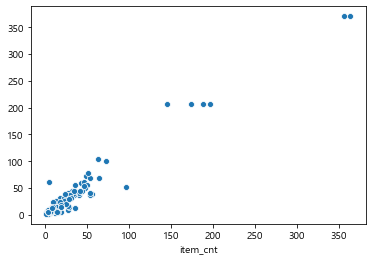

In [100]:
sns.scatterplot(y_true, y_pred)

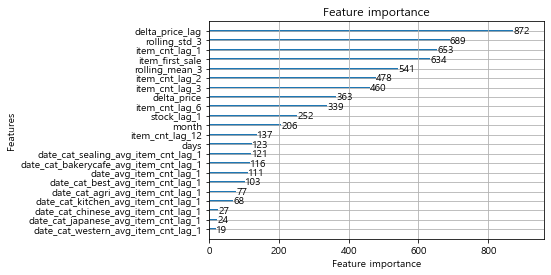

In [101]:
lgb.plot_importance(lgbm)

## XGB

In [108]:
tmp = []
for i in range(25, 28):
    X_train = data[data['ym'] <= i-1].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_train = data[data['ym'] <= i-1]['item_cnt']
    
    #X_valid = data[data['ym'] == i-1].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    #y_valid = data[data['ym'] == i-1]['item_cnt']
    
    X_test = data[data['ym'] == i].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_true = data[data['ym'] == i]['item_cnt']

    xgb = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        #min_child_weight=300, 
        #colsample_bytree=0.8, 
        #subsample=0.8, 
        #eta=0.3,    
        seed=42)

    xgb.fit(
        X_train, 
        y_train, 
        eval_metric="rmse", 
        #eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        verbose=True)#, 
        #early_stopping_rounds = 10)

    y_pred = xgb.predict(X_test)#, ntree_limit=xgb.best_ntree_limit).clip(0, )
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = MAPE(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    predict_res = {'RMSE' : rmse, 'R2' : r2}
    tmp.append(predict_res)
    #print(predict_res)import lightgbm as lgb

c:\users\minji\anaconda3\envs\jj\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\minji\anaconda3\envs\jj\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:52:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\minji\anaconda3\envs\jj\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\minji\anaconda3\envs\jj\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:52:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\minji\anaconda3\envs\jj\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\minji\anaconda3\envs\jj\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:53:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [109]:
tmp

[{'RMSE': 23.74206148832806, 'R2': 0.7302183042425634},
 {'RMSE': 29.640240897329427, 'R2': 0.6879373027237481},
 {'RMSE': 31.057163865727617, 'R2': 0.8334384312405487}]

In [114]:
cv_result['XGB'] = {'RMSE':np.mean([i['RMSE'] for i in tmp]), 'R2':np.mean([i['R2'] for i in tmp])}

In [115]:
cv_result

{'LGBM': {'RMSE': 25.903000383219602, 'R2': 0.8071231018384806},
 'XGB': {'RMSE': 28.1464887504617, 'R2': 0.7505313460689534}}

### 201905 예측

In [125]:
X_train = data[data['ym'] <= 27].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_train = data[data['ym'] <= 27]['item_cnt']

X_test = data[data['ym'] == 28].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_true = data[data['ym'] == 28]['item_cnt']

y_pred = xgb.predict(X_test)#, ntree_limit=xgb.best_ntree_limit).clip(0, )

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

final_result['XGB'] = { 'RMSE' : rmse, 'R2' : r2}

print('MSE : {:.3f} / RMSE : {:.3f} / MAPE : {:.3f}'.format(mse, rmse, mape))

MSE : 113.892 / RMSE : 10.672 / MAPE : 46.750


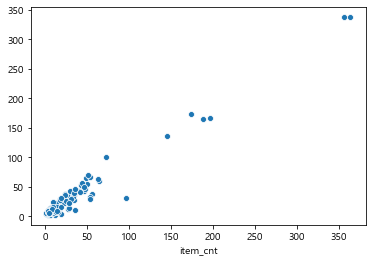

In [126]:
sns.scatterplot(y_true, y_pred)

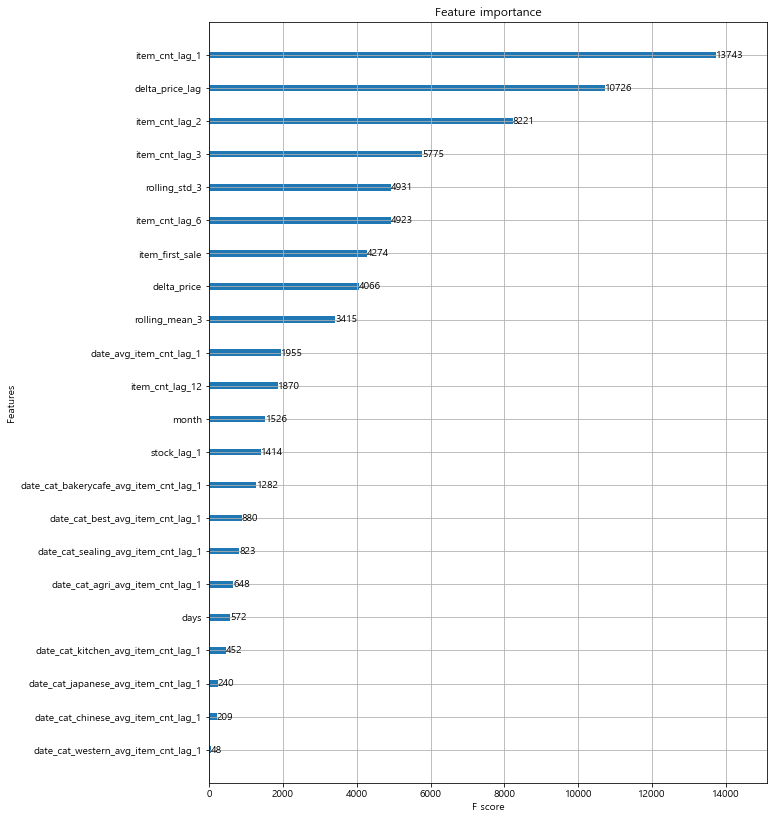

In [117]:
plot_features(xgb, (10,14))

## RF

In [155]:
from sklearn.ensemble import RandomForestRegressor

In [156]:
tmp = []
for i in range(25, 28):
    X_train = data[data['ym'] <= i-1].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_train = data[data['ym'] <= i-1]['item_cnt']
    
    X_test = data[data['ym'] == i].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_true = data[data['ym'] == i]['item_cnt']

    RF = RandomForestRegressor(max_depth=8, random_state=213, n_estimators=100)

    RF.fit(X_train, y_train)  

    y_pred = RF.predict(X_test).clip(0, )
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = MAPE(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    predict_res = {'RMSE' : rmse,'R2' : r2}
    tmp.append(predict_res)

In [157]:
tmp

[{'RMSE': 16.017437856021232, 'R2': 0.8772103603726992},
 {'RMSE': 19.749471942215518, 'R2': 0.8614554724473655},
 {'RMSE': 29.989013362183098, 'R2': 0.84469852841017}]

In [158]:
cv_result['RF'] = {'RMSE':np.mean([i['RMSE'] for i in tmp]), 'R2':np.mean([i['R2'] for i in tmp])}

In [159]:
cv_result

{'LGBM': {'RMSE': 25.903000383219602, 'R2': 0.8071231018384806},
 'XGB': {'RMSE': 28.1464887504617, 'R2': 0.7505313460689534},
 'RF': {'RMSE': 21.918641053473284, 'R2': 0.8611214537434115},
 'Extra': {'RMSE': 23.117175334678123, 'R2': 0.845747141449617}}

### 201905 예측

In [187]:
X_train = data[data['ym'] <= 27].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_train = data[data['ym'] <= 27]['item_cnt']

X_test = data[data['ym'] == 28].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_true = data[data['ym'] == 28]['item_cnt']

RF = RandomForestRegressor(max_depth=8, random_state=213, n_estimators=100)
RF.fit(X_train, y_train)  

y_pred = RF.predict(X_test)#, ntree_limit=xgb.best_ntree_limit).clip(0, )

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

final_result['RF'] = { 'RMSE' : rmse, 'R2' : r2}

print('RMSE : {:.3f} / R2 : {:.3f}'.format(rmse, r2))

RMSE : 20.110 / R2 : 0.857


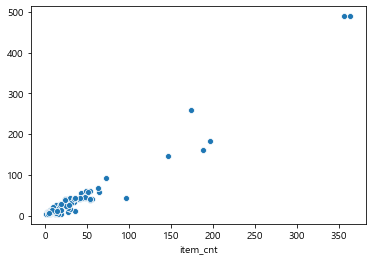

In [188]:
sns.scatterplot(y_true, y_pred)

In [189]:
#pd.concat([y_true.reset_index(drop=True), pd.DataFrame(y_pred)], 1)

In [190]:
importances = RF.feature_importances_
indices = np.argsort(importances)

In [210]:
importances

array([0.50892137, 0.17531115, 0.04304648, 0.02282181, 0.00097341,
       0.00099814, 0.00129905, 0.00111438, 0.00122456, 0.00118026,
       0.00140327, 0.00196121, 0.00229841, 0.00781251, 0.00656313,
       0.        , 0.        , 0.00544389, 0.14459568, 0.00346913,
       0.00615169, 0.00405675, 0.0022014 , 0.05316917, 0.00398315])

In [209]:
indices

array([16, 15,  4,  5,  7,  9,  8,  6, 10, 11, 22, 12, 19, 24, 21, 17, 20,
       14, 13,  3,  2, 23, 18,  1,  0], dtype=int64)

In [213]:
len(indices)

25

In [215]:
[features[i] for i in indices[15:]]

['rolling_std_3',
 'delta_price',
 'date_cat_kitchen_avg_item_cnt_lag_1',
 'date_cat_agri_avg_item_cnt_lag_1',
 'item_cnt_lag_6',
 'item_cnt_lag_3',
 'item_first_sale',
 'rolling_mean_3',
 'item_cnt_lag_2',
 'item_cnt_lag_1']

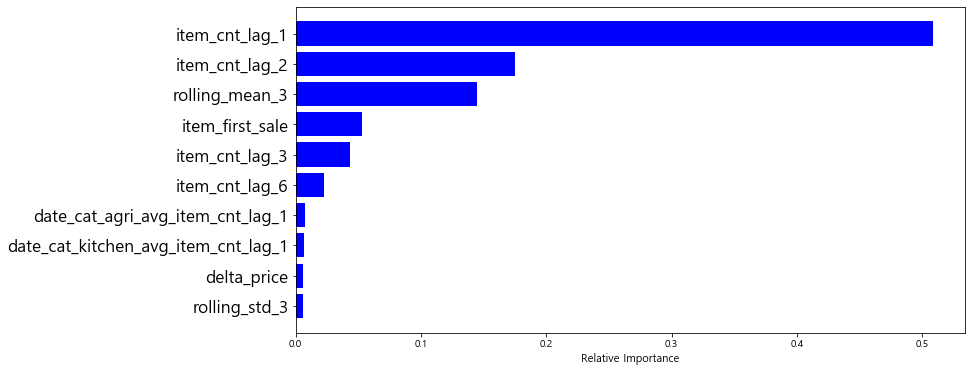

In [225]:
features = X_test.columns.values

plt.figure(figsize=(12,6))
#plt.title('Feature Importances', )
plt.barh(range(len(indices[15:])), importances[indices[15:]], color='b', align='center')
plt.yticks(range(len(indices[15:])), [features[i] for i in indices][15:], fontsize=17)
plt.xlabel('Relative Importance', fontsize=11)
plt.show()

In [228]:
import shap

In [229]:
# load JS visualization code to notebook
shap.initjs()

In [230]:
explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

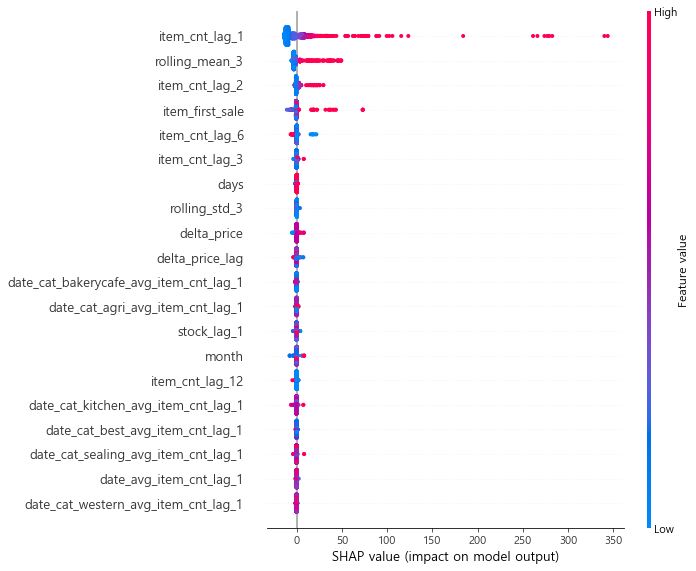

In [232]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

### ExtraTreesRegressor

In [165]:
from sklearn.ensemble import ExtraTreesRegressor

In [166]:
tmp = []
for i in range(25, 28):
    X_train = data[data['ym'] <= i-1].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_train = data[data['ym'] <= i-1]['item_cnt']
    
    X_test = data[data['ym'] == i].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
    y_true = data[data['ym'] == i]['item_cnt']

    extra = ExtraTreesRegressor(max_depth=8, random_state=213, n_estimators=100)

    extra.fit(X_train, y_train)  

    y_pred = extra.predict(X_test).clip(0, )
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = MAPE(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    predict_res = {'RMSE' : rmse,'R2' : r2}
    tmp.append(predict_res)

In [167]:
tmp

[{'RMSE': 15.725877412381218, 'R2': 0.881639878814846},
 {'RMSE': 21.949675645279726, 'R2': 0.8288666649803788},
 {'RMSE': 31.67597294637343, 'R2': 0.8267348805536264}]

In [168]:
cv_result['Extra'] = {'RMSE':np.mean([i['RMSE'] for i in tmp]), 'R2':np.mean([i['R2'] for i in tmp])}

In [169]:
cv_result

{'LGBM': {'RMSE': 25.903000383219602, 'R2': 0.8071231018384806},
 'XGB': {'RMSE': 28.1464887504617, 'R2': 0.7505313460689534},
 'RF': {'RMSE': 21.918641053473284, 'R2': 0.8611214537434115},
 'Extra': {'RMSE': 23.117175334678123, 'R2': 0.845747141449617}}

### 201905 예측

In [195]:
X_train = data[data['ym'] <= 27].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_train = data[data['ym'] <= 27]['item_cnt']

X_test = data[data['ym'] == 28].drop(['item_cnt', 'ym', 'prod_num'], axis=1)
y_true = data[data['ym'] == 28]['item_cnt']

extra = ExtraTreesRegressor(max_depth=8, random_state=213, n_estimators=100)
extra.fit(X_train, y_train)  
    
y_pred = extra.predict(X_test)#, ntree_limit=xgb.best_ntree_limit).clip(0, )

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

final_result['Extra'] = { 'RMSE' : rmse, 'R2' : r2}

print('RMSE : {:.3f} / R2 : {:.3f}'.format(rmse, r2))

RMSE : 19.830 / R2 : 0.861


In [196]:
final_result

{'LGBM': {'RMSE': 12.929259940737918, 'R2': 0.9409089100271357},
 'XGB': {'RMSE': 10.672017322074563, 'R2': 0.9597405618272206},
 'RF': {'RMSE': 20.110198242400447, 'R2': 0.8570423598276428},
 'Extra': {'RMSE': 19.830284147054947, 'R2': 0.860994321656209}}

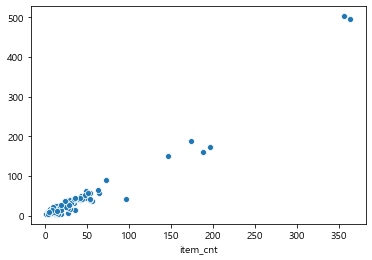

In [197]:
sns.scatterplot(y_true, y_pred)

In [198]:
#pd.concat([y_true.reset_index(drop=True), pd.DataFrame(Y_pred)], 1)

In [199]:
importances =extra.feature_importances_
indices = np.argsort(importances)

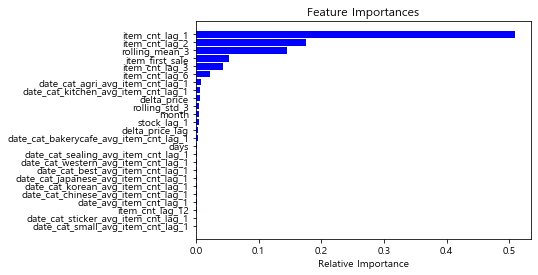

In [200]:
features = X_test.columns.values

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 평가

In [201]:
pd.DataFrame(cv_result)

,LGBM,XGB,RF,Extra
RMSE,25.90,28.15,21.92,23.12
R2,0.81,0.75,0.86,0.85


In [202]:
pd.DataFrame(final_result)#[['RF']].T

,LGBM,XGB,RF,Extra
RMSE,12.93,10.67,20.11,19.83
R2,0.94,0.96,0.86,0.86


In [203]:
final_result['RF']

{'RMSE': 20.110198242400447, 'R2': 0.8570423598276428}

# 결론

RF가 가장 좋은 성능을 보임